# Data Analysis in R

In [50]:
###### Libraries
#install.packages("SPARQL")
#install.packages("igraph")
#install.packages("kableExtra")
#install.packages("stringr")
#install.packages("dplyr")
#install.packages("knitr")
#install.packages("stringdist")
#install.packages("data.tree")
#install.packages("treemap")
#install.packages("shiny")
#install.packages("shinydashboard")
#install.packages("tidyverse")
#install.packages("xlsx")
#install.packages("png")
library(SPARQL)
library(igraph)
library(kableExtra)
library(stringr)
library(dplyr)
library(knitr)
library(stringdist)
library(data.tree)
library(treemap)
library(shiny)
library(shinydashboard)
library(tidyverse)
library(xlsx)
library(png)

In [51]:
###### Queries
MDquery <-
'
PREFIX owl:   <http://www.w3.org/2002/07/owl#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX mission: <http://imce.jpl.nasa.gov/foundation/mission/mission#>
PREFIX base:  <http://imce.jpl.nasa.gov/foundation/base/base#>
PREFIX fse-backbone: <http://imce.jpl.nasa.gov/backbone/imce.jpl.nasa.gov/discipline/fse/fse#>

SELECT DISTINCT ?Child ?Parent
FROM <urn:x-arq:UnionGraph>
WHERE
{
    ?a a owl:Class ;
       rdfs:label ?b ;
       rdfs:subClassOf mission:Component .
    filter not exists {?a rdfs:subClassOf fse-backbone:Entity} .
    filter not exists {?a rdfs:subClassOf <http://imce.jpl.nasa.gov/backbone/firesat.jpl.nasa.gov/user-model/generated/md/nonAuthorities/Requirements_ID__18_5_3_8c20287_1560995931030_118996_18400#Entity>} .
    
    ?c a owl:Class ;
       rdfs:label ?Child ;
       rdfs:subClassOf mission:Component .
    filter not exists {?c rdfs:subClassOf fse-backbone:Entity} .
    filter not exists {?c rdfs:subClassOf <http://imce.jpl.nasa.gov/backbone/firesat.jpl.nasa.gov/user-model/generated/md/nonAuthorities/Requirements_ID__18_5_3_8c20287_1560995931030_118996_18400#Entity>} .
    
    optional {?a rdfs:subClassOf [a owl:Restriction ;
                                    owl:onProperty base:contains ;
                                    owl:someValuesFrom ?c] }.

    optional {?e rdfs:subClassOf [a owl:Restriction ;
                                    owl:onProperty base:contains ;
                                     owl:someValuesFrom ?c ].
    		  ?e rdfs:label ?Parent }.
  }
'
WBquery <-
  '
PREFIX oml: <http://def.seegrid.csiro.au/ontology/om/om-lite#>
PREFIX owl:   <http://www.w3.org/2002/07/owl#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX fse:   <http://imce.jpl.nasa.gov/discipline/fse/fse#>
PREFIX base:  <http://imce.jpl.nasa.gov/foundation/base/base#>
PREFIX analysis: <http://imce.jpl.nasa.gov/foundation/analysis/analysis#>
PREFIX mission: <http://imce.jpl.nasa.gov/foundation/mission/mission#>

SELECT DISTINCT ?CanonicalName ?Identifier ?ParentAlternateName
FROM <urn:x-arq:UnionGraph>
WHERE
{
  ?a a mission:Component ;
     base:hasCanonicalName ?CanonicalName ;
     fse:hasAssemblyReferenceDesignator ?Identifier ;
     base:isContainedIn ?ContainedIn_ParentAssembly.
?ContainedIn_ParentAssembly base:hasCanonicalName ?ParentAlternateName.   
}  
  '
MDendpoint <- "http://localhost:3030/MD/query"
MDqr <- SPARQL(MDendpoint,MDquery)
MDqr <- MDqr$results
MDqr <- unique(MDqr)
MDqr <- MDqr[order(MDqr$Child, MDqr$Parent),]
MDp <- MDqr
MDqrOriginal <- MDqr
MDqr <- subset(MDqr, MDqr$Parent != "NA")
WBendpoint <- "http://localhost:3030/WBv11/query"
WBqr <- SPARQL(WBendpoint,WBquery)
WBqr <- WBqr$results
WBqr <- WBqr[ ,c('CanonicalName', 'ParentAlternateName')]
WBqr <- unique(WBqr)
colnames(WBqr)[colnames(WBqr)=="CanonicalName"] <- "Child"
colnames(WBqr)[colnames(WBqr)=="ParentAlternateName"] <- "Parent"
WBqr <- WBqr[order(WBqr$Child, WBqr$Parent),]
WBp <- WBqr
WBqrOriginal <- WBqr
WBqr <- subset(WBqr, WBqr$Parent != "NA")

In [52]:
###### Comparing results
### MagicDraw PBS graph format
MDg <- graph_from_data_frame(d=MDqr, directed=TRUE, vertices=NULL)
#plot.igraph(MDg)
#title(main = "MagicDraw PBS", sub = sprintf("Total: %d elements and %d relationships", gorder(MDg), gsize(MDg)))
### Workbench PBS graph format
WBg <- graph_from_data_frame(d=WBqr, directed=TRUE, vertices=NULL)
#plot.igraph(WBg)
#title(main = "Workbench PBS", sub = sprintf("Total: %d elements and %d relationships", gorder(WBg), gsize(WBg)))
### MagicDraw but not in WorkBench graph format
MD_not_WB <- difference(MDg, WBg)
#plot.igraph(MD_not_WB)
#title(main = "MD-WB : Differences from MagicDraw PBS to WorkBench PBS", sub = sprintf("From the %d elements present in MD PBS, here are displayed the %d relationships missing in WB PBS", gorder(MD_not_WB), gsize(MD_not_WB)))
### WorkBench but not in MagicDraw graph format
WB_not_MD <- difference(WBg, MDg)
#plot.igraph(WB_not_MD)
#title(main = "WB-MD : Differences from WorkBench PBS to MagicDraw PBS", sub = sprintf("From the %d elements present in WB PBS, here are displayed the %d relationships missing in MD PBS", gorder(WB_not_MD), gsize(WB_not_MD)))
### WorkBench and in MagicDraw graph format
WB_and_MD <- intersection(WBg, MDg)
#plot.igraph(WB_and_MD)
#title(main = "Intersection of MagicDraw PBS and WorkBench PBS", sub = sprintf("Here are displayed the %d unique elements from the WB and MD PBS, in addition to the %d relationships they have in common", gorder(WB_and_MD), gsize(WB_and_MD)))
testA <- get.data.frame(MD_not_WB, what="edges")
colnames(testA)[colnames(testA)=="from"] <- "Child"
colnames(testA)[colnames(testA)=="to"] <- "Parent"
testA$WorkBench <- ""
testA$MagicDraw <- "x"
#print(testA)
#nrow(testA)
testB <- get.data.frame(WB_not_MD, what="edges")
colnames(testB)[colnames(testB)=="from"] <- "Child"
colnames(testB)[colnames(testB)=="to"] <- "Parent"
testB$WorkBench <- "x"
testB$MagicDraw <- ""
testC <- get.data.frame(WB_and_MD, what="edges")
colnames(testC)[colnames(testC)=="from"] <- "Child"
colnames(testC)[colnames(testC)=="to"] <- "Parent"
testC$WorkBench <- "x"
testC$MagicDraw <- "x"
testD <- rbind(testA, testB, testC)
testD <- testD[order(testD$Child, testD$Parent),]

testF <- testA[ ,c('Child', 'Parent')]
testF$Origin <- "MagicDraw"
testF$Origin.type <- 1

testG <- testB[ ,c('Child', 'Parent')]
testG$Origin <- "WorkBench"
testG$Origin.type <- 2

testH <- testC[ ,c('Child', 'Parent')]
testH$Origin <- "WorkBench and MagicDraw"
testH$Origin.type <- 3

testI <- union(testF, testG)
testJ <- union(testI, testH)


A <- testJ
B <- testJ
col_order <- c("Parent", "Child", "Origin", "Origin.type")
colnames(B)[colnames(B)=="Parent"] <- "Child2"
colnames(B)[colnames(B)=="Child"] <- "Parent"
colnames(B)[colnames(B)=="Child2"] <- "Child"
D <- union_all(A,B)
colnames(D)[colnames(D)=="Child"] <- "Node"
D <- D[ ,c('Node', 'Origin', 'Origin.type')]
D <- D[order(D$Node),]
D <- unique(D)

D$Duplicate_Node <- duplicated(D$Node)
E <- subset(D, Duplicate_Node == TRUE)
F <- subset(D, Duplicate_Node == FALSE)
E$Origin <- "WorkBench and MagicDraw"
E$Origin.type <- 3
G <- union(E, F)
H <- G[ !( duplicated(G[,1])),]
H <- H[ ,c('Node', 'Origin', 'Origin.type')]
I <- H[ ,c('Node', 'Origin')]
I$WorkBench <- ""
I$MagicDraw <- ""
colnames(H)[colnames(H)=="Node"] <- "Child"
J <- subset(I, I$Origin == "WorkBench")
J$WorkBench <- "x"
K <- subset(I, I$Origin == "MagicDraw")
K$MagicDraw <- "x"
L <- subset(I, I$Origin == "WorkBench and MagicDraw")
L$WorkBench <- "x"
L$MagicDraw <- "x"
M <- rbind(J, K, L)
M <- M[ ,c('Node', 'WorkBench', 'MagicDraw')]
M <- M[order(M$Node),]

H <- H[order(H$Child),]
testJ <- testJ[order(testJ$Child),]
testK <- graph_from_data_frame(d=testJ, directed=TRUE, vertices=H)
colrs <- c("gray50", "tomato", "gold")
E(testK)$color <- colrs[E(testK)$Origin.type]
V(testK)$color <- colrs[V(testK)$Origin.type]
deg <-  degree(testK, mode="all")
V(testK)$size <- deg*1.5
V(testK)$label.cex <- 1
V(testK)$size <- 7
E(testK)$arrow.size <- .3

green <- c("", "green")
white <- c("black", "white")
#dir.create("/firesatReports")
#modifications <- data.frame(which(testD[slaves[1]] != testD[authorityPrompt[1]]))

V(WBg)$size <- deg*1.5
V(WBg)$label.cex <- 1
V(WBg)$size <- 7
E(WBg)$arrow.size <- .3
V(MDg)$size <- deg*1.5
V(MDg)$label.cex <- 1
V(MDg)$size <- 7
E(MDg)$arrow.size <- .3

ERROR: Error in `$<-.data.frame`(`*tmp*`, WorkBench, value = "x"): replacement has 1 row, data has 0


In [53]:
###### Graphs
png("WBgraph.png", width = 1000, height = 1000)
plot.igraph(WBg, edge.curved=.1, layout=layout_nicely)
dev.off()

png("MDgraph.png", width = 1000, height = 1000)
plot.igraph(MDg, edge.curved=.1, layout=layout_nicely)
dev.off()

png 
  2

png 
  2

In [54]:
###Treemaps
i <- 1
if (length(which(degree(MDg, mode="out") == 0)) == 1)
{
  while (i <= nrow(MDp))
  {
    if (is.na(MDp$Parent[i]))
    {
      MDroot <- (MDp$Child[i])
    }
    i <- i + 1
  }
  MDp <- subset(MDp, MDp$Parent != "NA")
  MDp <- subset(MDp, MDp$Parent != MDroot)
  MDp$pathString <- paste(MDroot, MDp$Parent, MDp$Child, sep = "/")
  MDtree <- as.Node(MDp)
  sink("MDtree.txt")
  print(ToDataFrameTree(MDtree, "level"))  
  sink()
  write.csv(MDtree, "MDtree.csv", row.names = FALSE)
}

i <- 1
if (length(which(degree(WBg, mode="out") == 0)) == 1)
{
  while (i <= nrow(WBp))
  {
    if (is.na(WBp$Parent[i]))
    {
      WBroot <- (WBp$Child[i])
    }
    i <- i + 1
  }
  WBp <- subset(WBp, WBp$Parent != "NA")
  WBp <- subset(WBp, WBp$Parent != WBroot)
  WBp$pathString <- paste(WBroot, wBp$Parent, WBp$Child, sep = "/")
  WBtree <- as.Node(wBp)
  sink("WBtree.txt")
  print(ToDataFrameTree(WBtree, "level"))  
  sink()
  write.csv(WBtree, "WBtree.csv", row.names = FALSE)
}

ERROR: Error in eval(e, x, parent.frame()): object 'WBroot' not found


In [55]:
### Are WorkBench and MagicDraw models well-formed?
Q <- data.frame("Test" = c("Connected", "Acyclic", "Directed", "Rooted"), 
                "WorkBench" = c(is.connected(WBg), girth(WBg)$girth == 0, is_directed(WBg), length(which(degree(WBg, mode="out") == 0)) == 1), 
                "MagicDraw" = c(is.connected(MDg), girth(MDg)$girth == 0, is_directed(MDg), length(which(degree(MDg, mode="out") == 0)) == 1))
WBwf <- FALSE
MDwf <- FALSE
if ((Q$MagicDraw[1] == TRUE) & (Q$MagicDraw[2] == TRUE) & (Q$MagicDraw[3] == TRUE) & (Q$MagicDraw[4] == TRUE))
{
  MDwf <- TRUE
  #column_spec(match("MagicDraw", colnames(Q)), background = "green", color = "white")
}
if ((Q$WorkBench[1] == TRUE) & (Q$WorkBench[2] == TRUE) & (Q$WorkBench[3] == TRUE) & (Q$WorkBench[4] == TRUE))
{
  WBwf <- TRUE
  #column_spec(match("WorkBench", colnames(Q)), background = "green", color = "white")
}

write.csv(Q,"wellformed.csv", row.names = FALSE)

kable(Q, align = c('l', 'c', 'c'), caption = print(sprintf("%d well-formedness checks performed", nrow(Q)))) %>%
  kable_styling("basic") %>%
  add_header_above(c("Are the models well-formed ?" = 3), font_size = 15) %>%
  column_spec(match("MagicDraw", colnames(Q)), background = green[1+MDwf], color = white[1+MDwf]) %>%
  column_spec(match("WorkBench", colnames(Q)), background = green[1+WBwf], color = white[1+WBwf]) %>%
  footnote(general = print(sprintf("The following models are not well-formed: %s %s", if (MDwf == FALSE){"MagicDraw"} else {""}, if (WBwf == FALSE){"WorkBench"} else {""}))) %>%
 save_kable("wellformed.html")

[1] "4 well-formedness checks performed"


ERROR: Error in column_spec_html_cell(target_cell, width, width_min, width_max, : object 'white' not found


In [56]:
###Display vertices
write.csv(M,"vertices.csv", row.names = FALSE)

kable(M, align = c('l', 'c', 'c'), caption = print(sprintf("%d unique vertices compared", nrow(M)))) %>%
  kable_styling("basic") %>%
  add_header_above(c("Are the vertices the same ?" = 4), font_size = 15) %>%
  #column_spec(1+match(authorityPrompt, colnames(M)), background = "green", color = "white")  
  #row_spec(which(N$authorityPrompt == "x" & N$), background = "green", color = "white") %>%
  #footnote(general = print(sprintf("You chose to identify %s as the source of authority. \n %d vertices unconsistencies need to be corrected.", authorityPrompt, nrow(N)))) %>%
  save_kable("vertices.html")

ERROR: Error in is.data.frame(x): object 'M' not found


In [57]:
###Display edges
write.csv(testD,"edges.csv", row.names = FALSE)

kable(testD, align = c('l', 'l', 'c', 'c'), caption = print(sprintf("%d unique edges compared", nrow(testD)))) %>%
  kable_styling("basic") %>%
  add_header_above(c("Are the edges the same ?" = 5), font_size = 15) %>%
  #column_spec(1+match(toString(slaves), colnames(testD)), background = "red", color = "white") %>%
  #column_spec(1+match(authorityPrompt, colnames(testD)), background = "green", color = "white")  
  #row_spec(which(testD[slaves[1]] == testD[authorityPrompt[1]]), background = "green", color = "white") %>%
  #footnote(general = print(sprintf("You chose to identify %s as the source of authority. \n %d edges unconsistencies need to be corrected.", authorityPrompt, nrow(modifications)))) %>%
  save_kable("edges.html")

ERROR: Error in is.data.frame(x): object 'testD' not found


In [58]:
###Display graph
png("WbMdGraphs.png", width = 1000, height = 1000)
plot.igraph(testK, edge.curved=.1, layout=layout_nicely)
legend(x=-1,  y=-1.1,  c  ("MagicDraw","WorkBench","WorkBench and MagicDraw"),  pch=21,  col="#777777",  pt.bg=colrs,  pt.cex=2,  cex=1,  bty="n",  ncol=1)
dev.off()

ERROR: Error in plot.igraph(testK, edge.curved = 0.1, layout = layout_nicely): object 'testK' not found


In [59]:
# UI

###Initializations
  
# Connected graph initialization
{
  WBconnectedActions <- ""
  MDconnectedActions <- ""
  WBConnectedG <- WBg
  MDConnectedG <- MDg
  if (is.connected(WBg) == FALSE)
  {
    if (no.clusters(WBg) > 1) 
    {
      WBconnectedActions <- tags$div(no.clusters(WBg), "isolated clusters found -> Connect the extra clusters.")
      i <- 1
      while (i <= no.clusters(WBg)) 
      {
        V(WBConnectedG)[which(clusters(WBg)$membership == i)]$color <- rainbow(no.clusters(WBg))[i]
        i <- i + 1
      }
    }
  }
  if (is.connected(MDg) == TRUE) {V(MDConnectedG)$color <- "green"}
  
  if (is.connected(MDg) == FALSE)
  {
    if (no.clusters(MDg) > 1) 
    {
      MDconnectedActions <- tags$div(no.clusters(MDg), "isolated clusters found -> Connect the extra clusters.")
      i <- 1
      while (i <= no.clusters(MDg)) 
      {
        V(MDConnectedG)[which(clusters(MDg)$membership == i)]$color <- rainbow(no.clusters(MDg))[i]
        i <- i + 1
      }
    }
  }
  if (is.connected(MDg) == TRUE) {V(MDConnectedG)$color <- "green"}
}

# Directed graph initialization
{
  WBdirectedG <- as.directed(WBg, mode = c("mutual"))
  MDdirectedG <- as.directed(MDg, mode = c("mutual"))
  nbOfUndirectedEdgesInWB <- gsize(WBdirectedG) - gsize(WBg)
  nbOfUndirectedEdgesInMD <- gsize(MDdirectedG) - gsize(MDg)
  WBDirectedG <- WBg
  MDDirectedG <- MDg
  WBdirectedActions <- ""
  MDdirectedActions <- ""
  if (is_directed(WBg) == FALSE)
  {
    WBdirectedActions <- tags$div(nbOfUndirectedEdgesInWB, "undirected edges found -> Look for them and direct them.")
  }
  if (is_directed(WBg) == TRUE) 
  {
    E(WBDirectedG)$color <- "green"
  }
  
  if (is_directed(MDg) == FALSE)
  {
    MDdirectedActions <- tags$div(nbOfUndirectedEdgesInMD, "undirected edges found -> Look for them and direct them.")
  }
  if (is_directed(MDg) == TRUE) 
  {
    E(MDDirectedG)$color <- "green"
  }
}

# Acyclic graph initialization
{
  WBacyclicG <- WBg
  MDacyclicG <- MDg
  WBcircleSizeWB <- girth(MDg)
  MDcircleSizeMD <- girth(MDg)
  WBacyclicActions <- ""
  MDacyclicActions <- ""
  V(WBacyclicG)$color <- "green"
  V(MDacyclicG)$color <- "green"
  V(WBacyclicG)[girth(WBacyclicG)$circle]$color <- "red"
  V(MDacyclicG)[girth(MDacyclicG)$circle]$color <- "red"
  V(WBacyclicG)[which(which_loop(WBg)==TRUE)]$color <- "red"
  V(MDacyclicG)[which(which_loop(MDg)==TRUE)]$color <- "red"
  if (girth(WBg)$girth != 0)
  {
    WBacyclicActions <- tags$div("One circle of ", WBcircleSizeWB, "nodes makes the WorkBench graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
  if (nrow(as.data.frame(which(which_loop(WBg)==TRUE))) != 0)
  {
    WBacyclicActions <- tags$div(nrow(as.data.frame(which(which_loop(WBg)==TRUE))), " loop(s) makes the WorkBench graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
  if (nrow(as.data.frame(which(which_loop(WBg)==TRUE))) != 0 & (girth(WBg)$girth != 0))
  {
    WBacyclicActions <- tags$div("One circle of ", WBcircleSizeWB, "nodes and ",  nrow(as.data.frame(which(which_loop(WBg)==TRUE))), " loop(s) make the WorkBench graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
  if (girth(MDg)$girth != 0)
  {
    MDacyclicActions <- tags$div("One circle of ", MDcircleSizeMD, "nodes makes the MagicDraw graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
  if (nrow(as.data.frame(which(which_loop(MDg)==TRUE))) != 0)
  {
    MDacyclicActions <- tags$div(nrow(as.data.frame(which(which_loop(MDg)==TRUE))), " loop(s) makes the MagicDraw graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
  if (nrow(as.data.frame(which(which_loop(MDg)==TRUE))) != 0 & (girth(MDg)$girth != 0))
  {
    MDacyclicActions <- tags$div("One circle of ", MDcircleSizeMD, "nodes and ",  nrow(as.data.frame(which(which_loop(MDg)==TRUE))), " loop(s) make the MagicDraw graph cyclic -> Correct the related edges to build an acyclic graph.")
  }
}

# Rooted graph initialization
{
  WBrootedG <- WBg
  MDrootedG <- MDg
  nbOfrootsInWB <- length(which(degree(WBg, mode="out") == 0))
  nbOfrootsInMD <- length(which(degree(MDg, mode="out") == 0))
  WBrootedActions <- ""
  MDrootedActions <- ""
  V(WBrootedG)[which(degree(WBg, mode="out") != 0)]$color <- "yellow"
  V(MDrootedG)[which(degree(MDg, mode="out") != 0)]$color <- "yellow"
  V(WBrootedG)[which(degree(WBg, mode="out") == 0)]$color <- "green"
  V(MDrootedG)[which(degree(MDg, mode="out") == 0)]$color <- "green"
  if (length(which(degree(WBg, mode="out") == 0)) > 1)
  {
    WBrootedActions <- tags$div(nbOfrootsInWB, "roots found instead of 1 -> Correct the extra roots.")
    V(WBrootedG)[which(degree(WBg, mode="out") == 0)]$color <- "red"
    V(WBrootedG)[which(degree(WBg, mode="out") != 0)]$color <- "yellow"
  }
  if (length(which(degree(WBg, mode="out") == 0)) == 0)
  {
    WBrootedActions <- tags$div(nbOfrootsInWB, "root found instead of 1 -> Build one root.")
  }
  if (length(which(degree(MDg, mode="out") == 0)) > 1)
  {
    MDrootedActions <- tags$div(nbOfrootsInMD, "roots found instead of 1 -> Correct the extra roots.")
    V(MDrootedG)[which(degree(MDg, mode="out") == 0)]$color <- "red"
    V(MDrootedG)[which(degree(MDg, mode="out") != 0)]$color <- "yellow"
  }
  if (length(which(degree(MDg, mode="out") == 0)) == 0)
  {
    MDrootedActions <- tags$div(nbOfrootsInMD, "root found instead of 1 -> Build one root.")
  }
}


# Preparation of the outputs

## UI Part I

In [60]:
write.csv("KO", file = "WBwf.csv",row.names=FALSE)
write.csv("KO", file = "MDwf.csv",row.names=FALSE)

if (WBwf == TRUE)
{
    write.csv("OK", file = "WBwf.csv",row.names=FALSE)
    png("WBwfResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}

if (WBwf != TRUE)
{
    png("WBwfResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}


if (MDwf == TRUE)
{
    write.csv("OK", file = "MDwf.csv",row.names=FALSE)
    png("MDwfResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}

if (MDwf != TRUE)
{
    png("MDwfResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}

png 
  2

png 
  2

In [61]:
png("WBConnectedG.png", width = 1000, height = 1000)
plot.igraph(WBConnectedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("WBDirectedG.png", width = 1000, height = 1000)
plot.igraph(WBDirectedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("WBacyclicG.png", width = 1000, height = 1000)
plot.igraph(WBacyclicG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("WBrootedG.png", width = 1000, height = 1000)
plot.igraph(WBrootedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("MDConnectedG.png", width = 1000, height = 1000)
plot.igraph(MDConnectedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("MDDirectedG.png", width = 1000, height = 1000)
plot.igraph(MDDirectedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("MDacyclicG.png", width = 1000, height = 1000)
plot.igraph(MDacyclicG, edge.curved=.1, layout=layout_nicely)
dev.off()

png("MDrootedG.png", width = 1000, height = 1000)
plot.igraph(MDrootedG, edge.curved=.1, layout=layout_nicely)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [62]:
WBactionsToPerform <- tags$div(WBconnectedActions, WBacyclicActions, WBdirectedActions, WBrootedActions)
capture.output(WBactionsToPerform, file = "WBactionsToPerform.html")

MDactionsToPerform <- tags$div(MDconnectedActions, MDacyclicActions, MDdirectedActions, MDrootedActions)
capture.output(MDactionsToPerform, file = "MDactionsToPerform.html")

In [63]:
if (is.connected(WBg) == TRUE)
{
    WBconnectedReport <- tags$div("The graph is connected.", br(), "No action to perform.")
    png("WBconnectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (is.connected(WBg) != TRUE)
{
    WBconnectedReport <- WBconnectedActions
    png("WBconnectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(WBconnectedReport, file = "WBconnectedReport.html")


if (is.connected(MDg) == TRUE)
{
    MDconnectedReport <- tags$div("The graph is connected.", br(), "No action to perform.")
    png("MDconnectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (is.connected(MDg) != TRUE)
{
    MDconnectedReport <- MDconnectedActions
    png("MDconnectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(MDconnectedReport, file = "MDconnectedReport.html")

png 
  2

png 
  2

In [64]:
if ((girth(WBg)$girth == 0) & (nrow(as.data.frame(which(which_loop(WBg)==TRUE))) == 0))
{
    WBacyclicReport <- tags$div("The graph is acyclic.", br(), "No action to perform.")
    png("WBacyclicResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if ((girth(WBg)$girth != 0) | (nrow(as.data.frame(which(which_loop(WBg)==TRUE))) != 0))
{
    WBacyclicReport <- WBacyclicActions
    png("WBacyclicResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(WBacyclicReport, file = "WBacyclicReport.html")


if ((girth(MDg)$girth == 0) & (nrow(as.data.frame(which(which_loop(MDg)==TRUE))) == 0))
{
    MDacyclicReport <- tags$div("The graph is acyclic.", br(), "No action to perform.")
    png("MDacyclicResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if ((girth(MDg)$girth != 0) | (nrow(as.data.frame(which(which_loop(MDg)==TRUE))) != 0))
{
    MDacyclicReport <- MDacyclicActions
    png("MDacyclicResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(MDacyclicReport, file = "MDacyclicReport.html")

png 
  2

png 
  2

In [65]:
if (is_directed(WBg) == TRUE)
{
    WBdirectedReport <- tags$div("The graph is directed.", br(), "No action to perform.")
    png("WBdirectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (is_directed(WBg) != TRUE)
{
    WBdirectedReport <- WBdirectedActions
    png("WBdirectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(WBdirectedReport, file = "WBdirectedReport.html")


if (is_directed(MDg) == TRUE)
{
    MDdirectedReport <- tags$div("The graph is directed.", br(), "No action to perform.")
    png("MDdirectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (is_directed(MDg) != TRUE)
{
    MDdirectedReport <- MDdirectedActions
    png("MDdirectedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(MDdirectedReport, file = "MDdirectedReport.html")

png 
  2

png 
  2

In [66]:
if (length(which(degree(WBg, mode="out") == 0)) == 1)
{
    WBrootedReport <- tags$div("The graph is rooted.", br(), "No action to perform.")
    png("WBrootedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (length(which(degree(WBg, mode="out") == 0)) != 1)
{
    WBrootedReport <- WBrootedActions
    png("WBrootedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(WBrootedReport, file = "WBrootedReport.html")


if (length(which(degree(MDg, mode="out") == 0)) == 1)
{
    MDrootedReport <- tags$div("The graph is rooted.", br(), "No action to perform.")
    png("MDrootedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("OK.png"))
    dev.off()
}
if (length(which(degree(MDg, mode="out") == 0)) != 1)
{
    MDrootedReport <- MDrootedActions
    png("MDrootedResult.png", width = 1000, height = 1000)
    grid::grid.raster(readPNG("KO.png"))
    dev.off()
}
capture.output(MDrootedReport, file = "MDrootedReport.html")

png 
  2

png 
  2

In [67]:
capture.output(WBconnectedActions, file = "WBconnectedActions.html")
capture.output(WBacyclicActions, file = "WBacyclicActions.html")
capture.output(WBdirectedActions, file = "WBdirectedActions.html")
capture.output(WBrootedActions, file = "WBrootedActions.html")

capture.output(MDconnectedActions, file = "MDconnectedActions.html")
capture.output(MDacyclicActions, file = "MDacyclicActions.html")
capture.output(MDdirectedActions, file = "MDdirectedActions.html")
capture.output(MDrootedActions, file = "MDrootedActions.html")

## UI Part II

In [68]:
## Vertices analysis MD

#authorityPrompt <- "MagicDraw"
#slaves <- "WorkBench"

OSA = matrix(ncol = nrow(K), nrow = nrow(J))
SNX = matrix(ncol = nrow(K), nrow = nrow(J))
Nmd <- J
Nmd <- Nmd[ ,c('Node', 'Origin')]
i <- 1
while (i <= nrow(J))
{
  j <- 1
  while (j <= nrow(K))
  {
    OSA[i, j] <- stringdist(J$Node[i],  K$Node[j], method = c("osa"))
    SNX[i, j] <- stringdist(J$Node[i],  K$Node[j], method = c("soundex"))
    j <- j + 1
  }
  if (min(SNX[i,]) == 0)
  {
    Nmd$ClosestTarget_Name[i] <- K[match (0, SNX[i,]),1]
    Nmd$Comment[i] <- sprintf("Suspected spelling mistake in %s", "WorkBench")
  }
  else
  {
    if ((min(SNX[i,]) != 0) & (min(OSA[i,]) < 75/100*nchar(Nmd$Node[i])))
    {
      Nmd$ClosestTarget_Name[i] <- K[match(min(OSA[i,]), OSA[i,]),1]
      Nmd$Comment[i] <- sprintf("Suspected spelling mistake in %s", "WorkBench")
    }
    else
    {
      Nmd$ClosestTarget_Name[i] <- "-"  
      Nmd$Comment[i] <- sprintf("Suspected extra element in %s", "WorkBench")
    }
  }
  i <- i + 1
}
Omd <- Nmd[0,]
Omd <- as.data.frame(setdiff(K$Node, Nmd$ClosestTarget_Name))
colnames(Omd)[colnames(Omd)=="setdiff(K$Node, Nmd$ClosestTarget_Name)"] <- "Node"
Omd$Origin <- "MagicDraw"
Omd$ClosestTarget_Name <- "-"
Omd$Comment <- sprintf("Suspected missing element in %s", "WorkBench")
Nmd <- rbind(Nmd, Omd)


## Display vertices analysis MD
colnames(Nmd)[colnames(Nmd)=="Node"] <- "AttributeOfVertice_Name"

i <- 1
j <- 1
while (j <= nrow(Nmd))
{
  i <- 1
  while (i <= vcount(WBg))
  {
    if (Nmd$AttributeOfVertice_Name[j] == V(WBg)$name[i])
    {
      Nmd$AttributeOfVertice_Degree[j] <- degree(WBg, mode = c("all"))[i]
    }
    i <- i+1
  }
  j <- j+1
}

Nmd$FYI_ClosestTarget_Degree <- ""
i <- 1
j <- 1
while (j <= nrow(Nmd))
{
  i <- 1
  while (i <= vcount(MDg))
  {
    if ((Nmd$ClosestTarget_Name[j] == V(MDg)$name[i]) && (Nmd$ClosestTarget_Name[j] != "-"))
    {
      Nmd$FYI_ClosestTarget_Degree[j] <- degree(MDg, mode = c("all"))[i]
    }
    i <- i+1
  }
  j <- j+1
}

Nmd <- Nmd[ ,c('AttributeOfVertice_Name', 'AttributeOfVertice_Degree', 'Origin', 'ClosestTarget_Name', 'Comment', 'FYI_ClosestTarget_Degree')]

kable(Nmd, align = c('l', 'c', 'l', 'l'), caption = print(sprintf("%d vertices unconsistency analyzed", nrow(Nmd)))) %>%
  kable_styling("basic") %>%
  add_header_above(c("Analysis of the vertices" = 7), font_size = 15) %>%
  #column_spec(1+match(authorityPrompt, colnames(M)), background = "green", color = "white")  %>%
  #row_spec(which(N$authorityPrompt == "x" & N$), background = "green", color = "white") %>%
  #footnote(general = print(sprintf("You chose to identify %s as the source of authority.", authorityPrompt))) %>%
  save_kable("verticesAnalysisMD.html")

ERROR: Error in nrow(J): object 'J' not found


In [69]:
## Vertices analysis WB

#authorityPrompt <- "WorkBench"
#slaves <- "MagicDraw"

OSA = matrix(ncol = nrow(J), nrow = nrow(K))
SNX = matrix(ncol = nrow(J), nrow = nrow(K))
Nwb <- K
Nwb <- Nwb[ ,c('Node', 'Origin')]
i <- 1
while (i <= nrow(K))
{
  j <- 1
  while (j <= nrow(J))
  {
    OSA[i, j] <- stringdist(K$Node[i],  J$Node[j], method = c("osa"))
    SNX[i, j] <- stringdist(K$Node[i],  J$Node[j], method = c("soundex"))
    j <- j + 1
  }
  if (min(SNX[i,]) == 0)
  {
    Nwb$ClosestTarget_Name[i] <- J[match (0, SNX[i,]),1]
    Nwb$Comment[i] <- sprintf("Suspected spelling mistake in %s", "MagicDraw")
  }
  else
  {
    if ((min(SNX[i,]) != 0) & (min(OSA[i,]) < 75/100*nchar(Nwb$Node[i])))
    {
      Nwb$ClosestTarget_Name[i] <- J[match(min(OSA[i,]), OSA[i,]),1]
      Nwb$Comment[i] <- sprintf("Suspected spelling mistake in %s", "MagicDraw")
    }
    else
    {
      Nwb$ClosestTarget_Name[i] <- "-"  
      Nwb$Comment[i] <- sprintf("Suspected extra element in %s", "MagicDraw")
    }
  }
  i <- i + 1
}
Owb <- Nwb[0,]
Owb <- as.data.frame(setdiff(J$Node, Nwb$ClosestTarget_Name))
colnames(Owb)[colnames(Owb)=="setdiff(J$Node, Nwb$ClosestTarget_Name)"] <- "Node"
Owb$Origin <- "WorkBench"
Owb$ClosestTarget_Name <- "-"
Owb$Comment <- sprintf("Suspected missing element in %s", "MagicDraw")
Nwb <- rbind(Nwb, Owb)


## Display vertices analysis WB
colnames(Nwb)[colnames(Nwb)=="Node"] <- "AttributeOfVertice_Name"

i <- 1
j <- 1
while (j <= nrow(Nwb))
{
  i <- 1
  while (i <= vcount(MDg))
  {
    if (Nwb$AttributeOfVertice_Name[j] == V(MDg)$name[i])
    {
      Nwb$AttributeOfVertice_Degree[j] <- degree(MDg, mode = c("all"))[i]
    }
    i <- i+1
  }
  j <- j+1
}

Nwb$FYI_ClosestTarget_Degree <- ""
i <- 1
j <- 1
while (j <= nrow(Nwb))
{
  i <- 1
  while (i <= vcount(WBg))
  {
    if ((Nwb$ClosestTarget_Name[j] == V(WBg)$name[i]) && (Nwb$ClosestTarget_Name[j] != "-"))
    {
      Nwb$FYI_ClosestTarget_Degree[j] <- degree(WBg, mode = c("all"))[i]
    }
    i <- i+1
  }
  j <- j+1
}

Nwb <- Nwb[ ,c('AttributeOfVertice_Name', 'AttributeOfVertice_Degree', 'Origin', 'ClosestTarget_Name', 'Comment', 'FYI_ClosestTarget_Degree')]

kable(Nwb, align = c('l', 'c', 'l', 'l'), caption = print(sprintf("%d vertices unconsistency analyzed", nrow(Nwb)))) %>%
  kable_styling("basic") %>%
  add_header_above(c("Analysis of the vertices" = 7), font_size = 15) %>%
  #column_spec(1+match(authorityPrompt, colnames(M)), background = "green", color = "white")  %>%
  #row_spec(which(N$authorityPrompt == "x" & N$), background = "green", color = "white") %>%
  #footnote(general = print(sprintf("You chose to identify %s as the source of authority.", authorityPrompt))) %>%
  save_kable("verticesAnalysisWB.html")

ERROR: Error in nrow(K): object 'K' not found


In [70]:
### Are the WorkBench and MagicDraw graphs isomorphic?

png("WBandMDisomorphic.png", width = 25, height = 25)
if (isomorphic(MDg, WBg, method = c("auto")) != TRUE)
{
    grid::grid.raster(readPNG("KO.png"))
    write.csv("KO", file = "WBandMDisomorphic.csv",row.names=FALSE)
}
if (isomorphic(MDg, WBg, method = c("auto")) == TRUE)
{
    grid::grid.raster(readPNG("OK.png"))
    write.csv("OK", file = "WBandMDisomorphic.csv",row.names=FALSE)
}
dev.off()

df <- data.frame(c("", "Number of vertices", "Number of edges"), c("WorkBench", vcount(WBg), ecount(WBg)), c("MagicDraw", vcount(MDg), ecount(MDg)))
colnames(df) <- NULL
kable(df, align = c('l', 'c', 'c')) %>%
  kable_styling("basic") %>%
save_kable("isomorphicEdgeVerticeTable.html")

degreeMDg <- degree(MDg, mode = c("all"))
degreeMDg <- as.data.frame(sort.int(degreeMDg,decreasing=TRUE,index.return=FALSE))
degreeMDg <- degreeMDg[,1]
degreeWBg <- degree(WBg, mode = c("all"))
degreeWBg <- as.data.frame(sort.int(degreeWBg,decreasing=TRUE,index.return=FALSE))
degreeWBg <- degreeWBg[,1]
degreeDiff <- nrow(as.data.frame(setdiff(degreeWBg, degreeMDg)))
isomorphicEdgeVerticeResult <- ""
isomorphicActions <- ""
EorVcountResult <- ""
DegreeCountResult <- ""
if ((vcount(WBg) == vcount(MDg)) && (ecount(WBg) != ecount(MDg))) {
    EorVcountResult <- write.csv("KO", file = "EorVcountResult.csv",row.names=FALSE)
    isomorphicEdgeVerticeResult <- tags$div(
        "The WorkBench and MagicDraw models each contains ", vcount(WBg), " vertices." , br(), 
        "The WorkBench model contains ", ecount(WBg), " edges, whereas the MagicDraw model contains ", ecount(MDg), " edges -> Investigate the issue.")
    isomorphicActions <- tags$div(
        "The WorkBench model contains ", ecount(WBg), " edges, whereas the MagicDraw model contains ", ecount(MDg), " edges -> Investigate the issue.")
}
if ((vcount(WBg) != vcount(MDg)) && (ecount(WBg) == ecount(MDg))) {
    EorVcountResult <- write.csv("KO", file = "EorVcountResult.csv",row.names=FALSE)
    isomorphicEdgeVerticeResult <- tags$div(
        "The WorkBench model contains ", vcount(WBg), " vertices, whereas the MagicDraw model contains ", vcount(MDg), " vertices -> Investigate the issue." , br(), 
        "The WorkBench and MagicDraw models each contains ", ecount(WBg), " edges.")
    isomorphicActions <- tags$div(
        "The WorkBench model contains ", vcount(WBg), " vertices, whereas the MagicDraw model contains ", vcount(MDg), " vertices -> Investigate the issue.")
}
if ((vcount(WBg) != vcount(MDg)) && (ecount(WBg) != ecount(MDg))) {
    EorVcountResult <- write.csv("KO", file = "EorVcountResult.csv",row.names=FALSE)
    isomorphicEdgeVerticeResult <- tags$div(
        "The WorkBench model contains ", vcount(WBg), " vertices, whereas the MagicDraw model contains ", vcount(MDg), " vertices -> Investigate the issue." , br(), 
        "The WorkBench model contains ", ecount(WBg), " edges, whereas the MagicDraw model contains ", ecount(MDg), " edges -> Investigate the issue.")
    isomorphicActions <- isomorphicEdgeVerticeResult
}

if ((vcount(WBg) == vcount(MDg)) && (ecount(WBg) == ecount(MDg))) {
    EorVcountResult <- write.csv("OK", file = "EorVcountResult.csv",row.names=FALSE)
    isomorphicEdgeVerticeResult <- tags$div(
        "The WorkBench and MagicDraw models each contains ", vcount(WBg), " vertices." , br(), 
        "The WorkBench and MagicDraw models each contains ", ecount(WBg), " edges.")
    }

capture.output(isomorphicEdgeVerticeResult, file = "isomorphicEdgeVerticeResult.html")
capture.output(isomorphicActions, file = "isomorphicActions.html")

png 
  2

In [71]:
### Do the WorkBench and MagicDraw graphs share the same degrees' list?

degreeMDg <- degree(MDg, mode = c("all"))
degreeMDg <- as.data.frame(sort.int(degreeMDg,decreasing=TRUE,index.return=FALSE))
degreeMDg <- as.data.frame((degreeMDg))
degreeMDg <- degreeMDg[,1]
degreeWBg <- degree(WBg, mode = c("all"))
degreeWBg <- as.data.frame(sort.int(degreeWBg,decreasing=TRUE,index.return=FALSE))
degreeWBg <- degreeWBg[,1]

degree <- tags$div(
    "Degrees list of the WorkBench graph : ", toString(degreeWBg), br(), 
    "Degrees list of the MagicDraw graph : ", toString(degreeMDg))
capture.output(degree, file = "degree.html")

if (degreeWBg != degreeMDg)
{
    isomorphicDegreeResult <- tags$div(
        "There are", nrow(as.data.frame(setdiff(degreeWBg, degreeMDg))), "degrees values that are in the WorkBench degrees list but not in the MagicDraw : ", toString(setdiff(degreeWBg, degreeMDg)), "-> Investigate the issue.", br(), 
        "There are", nrow(as.data.frame(setdiff(degreeMDg, degreeWBg))), "degrees values that are in the MagicDraw degrees list but not in the WorkBench : ", toString(setdiff(degreeMDg, degreeWBg)), "-> Investigate the issue.")
    isomorphicActions <- tags$div(isomorphicActions, br(), isomorphicDegreeResult)
}

if (degreeWBg == degreeMDg)
{
    isomorphicDegreeResult <- tags$div(
        "The MagicDraw and WorkBench graphs both show the same degrees values.")
}

capture.output(isomorphicDegreeResult, file = "isomorphicDegreeResult.html")
capture.output(isomorphicActions, file = "isomorphicActions.html")

Warning message in degreeWBg != degreeMDg:
"longer object length is not a multiple of shorter object length"
Warning message in if (degreeWBg != degreeMDg) {:
"the condition has length > 1 and only the first element will be used"
Warning message in degreeWBg == degreeMDg:
"longer object length is not a multiple of shorter object length"
Warning message in if (degreeWBg == degreeMDg) {:
"the condition has length > 1 and only the first element will be used"


In [72]:
### Mutually non adjacent vertices

MDgTest <- MDg
MDgVlist <- vertex_attr(MDgTest)$name
NbNonAdjVerticeMD <- list()
j <- 1
while (j <= 10)
{
  while (length(E(MDgTest))!=0)
  {
    x <- (neighbors(MDgTest, MDgVlist[sample(1:length(MDgVlist), 1, replace=FALSE)], mode = c("all")))
    MDgTest <- delete_vertices(MDgTest, x)
    MDgVlist <- vertex_attr(MDgTest)$name
  }
  NbNonAdjVerticeMD[j] <- length(vertex_attr(MDgTest)$name)
  MDgTest <- MDg
  MDgVlist <- vertex_attr(MDgTest)$name
  j <- j+1
}
MaxNbNonAdjVerticeMD <- max(unlist(NbNonAdjVerticeMD))

WBgTest <- WBg
WBgVlist <- vertex_attr(WBgTest)$name
NbNonAdjVerticeWB <- list()
j <- 1
while (j <= 10)
{
  while (length(E(WBgTest))!=0)
  {
    x <- (neighbors(WBgTest, WBgVlist[sample(1:length(WBgVlist), 1, replace=FALSE)], mode = c("all")))
    WBgTest <- delete_vertices(WBgTest, x)
    WBgVlist <- vertex_attr(WBgTest)$name
  }
  NbNonAdjVerticeWB[j] <- length(vertex_attr(WBgTest)$name)
  WBgTest <- WBg
  WBgVlist <- vertex_attr(WBgTest)$name
  j <- j+1
}
MaxNbNonAdjVerticeWB <- max(unlist(NbNonAdjVerticeWB))

if (MaxNbNonAdjVerticeWB != MaxNbNonAdjVerticeMD)
{
    NbNonAdjVerticeResult <- tags$div("The WorkBench graph shows a maximum list of", MaxNbNonAdjVerticeWB, "non adjacent vertices, wheras the MagicDraw graph shows a maximum list of", MaxNbNonAdjVerticeMD, "non adjacent vertices -> Investigate the issue." )
    isomorphicActions <- tags$div(isomorphicActions, br(), NbNonAdjVerticeResult)
}
if (MaxNbNonAdjVerticeWB == MaxNbNonAdjVerticeMD) 
{
    NbNonAdjVerticeResult <- tags$div("The WorkBench and MagicDraw graphs both show a maximum list of", MaxNbNonAdjVerticeWB, "non adjacent vertices." )           
}
capture.output(NbNonAdjVerticeResult, file = "NbNonAdjVerticeResult.html")
capture.output(isomorphicActions, file = "isomorphicActions.html")

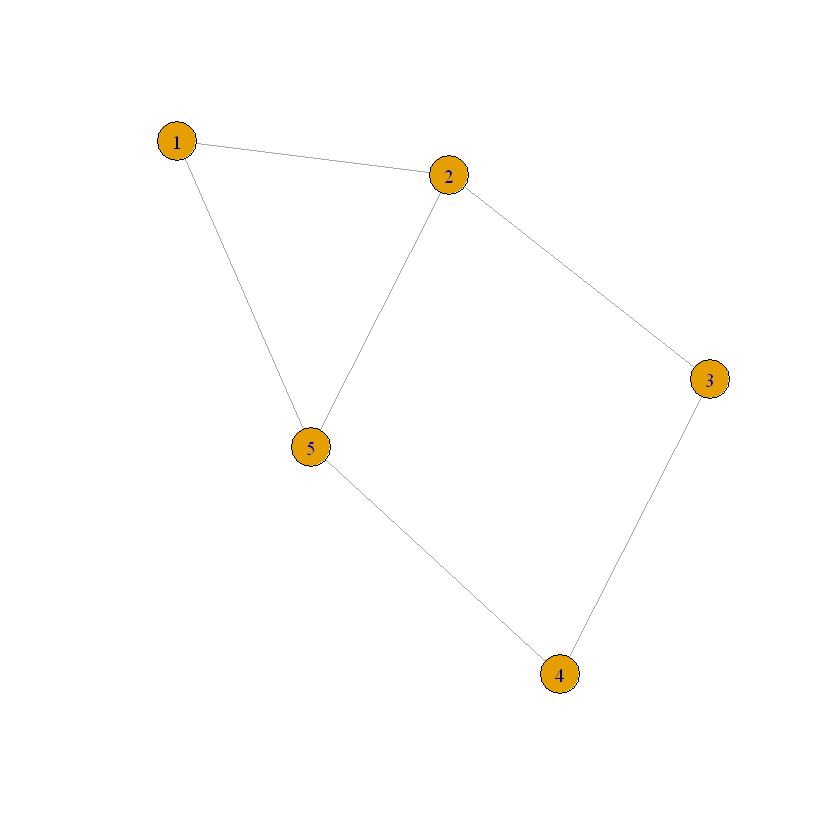

+ 5/9 vertices, named, from bf3f6ee:
[1] 1 2 4 6 7

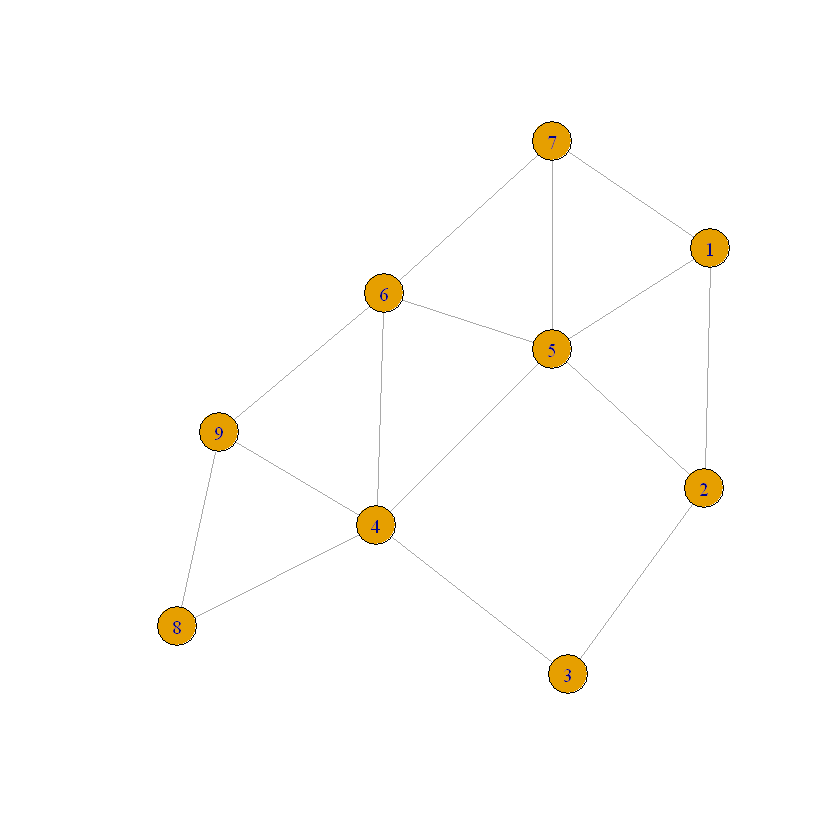

In [73]:
pattern <- make_graph(~ 1:2:3:4:5,
                      1 - 2:5, 2 - 1:5:3, 3 - 2:4, 4 - 3:5, 5 - 4:2:1)
plot.igraph(pattern)

target <- make_graph(~ 1:2:3:4:5:6:7:8:9,
                    1 - 2:5:7, 2 - 1:5:3, 3 - 2:4, 4 - 3:5:6:8:9,
                    5 - 1:2:4:6:7, 6 - 7:5:4:9, 7 - 1:5:6,
                    8 - 4:9, 9 - 6:4:8)
plot.igraph(target)

neighbors(target,5)

In [74]:
graph.count.subisomorphisms.vf2(pattern, target)
graph.get.subisomorphisms.vf2(pattern, target)

graph.count.subisomorphisms.vf2(target, pattern)
graph.get.subisomorphisms.vf2(target, pattern)

[1] 0

list()

[1] 20

[[1]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 1 2 3 4 5

[[2]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 1 5 4 3 2

[[3]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 1 5 4 6 7

[[4]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 1 7 6 4 5

[[5]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 2 1 7 6 5

[[6]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 2 5 6 7 1

[[7]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 4 5 1 7 6

[[8]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 4 6 7 1 5

[[9]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 5 4 8 9 6

[[10]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 5 6 9 8 4

[[11]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 6 4 3 2 5

[[12]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 6 5 2 1 7

[[13]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 6 5 2 3 4

[[14]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 6 7 1 2 5

[[15]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 7 5 4 9 6

[[16]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 7 6 9 4 5

[[17]]
+ 5/9 vertices, named, from bf3f6ee:
[1] 8 4 5 6 9

[[18]]